<a href="https://colab.research.google.com/github/alfi-sh1143/git-remote-add-origin-https-github.com-alfi1143-traffic-deadlock-manual/blob/main/XAI_for_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
!pip install shap lime -q
!pip install xgboost -q

import pandas as pd
import numpy as np
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb


In [100]:
url = "/content/creditcard.csv"
df = pd.read_csv(url)

df.head()


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [101]:
# Drop rows with NaN values in the 'Class' column
df_cleaned = df.dropna(subset=['Class'])

X = df_cleaned.drop('Class', axis=1)
y = df_cleaned['Class']

# Train-test split with stratification due to imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Data split successfully.")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Data split successfully.
Shape of X_train: (227845, 30)
Shape of X_test: (56962, 30)
Shape of y_train: (227845,)
Shape of y_test: (56962,)


In [102]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



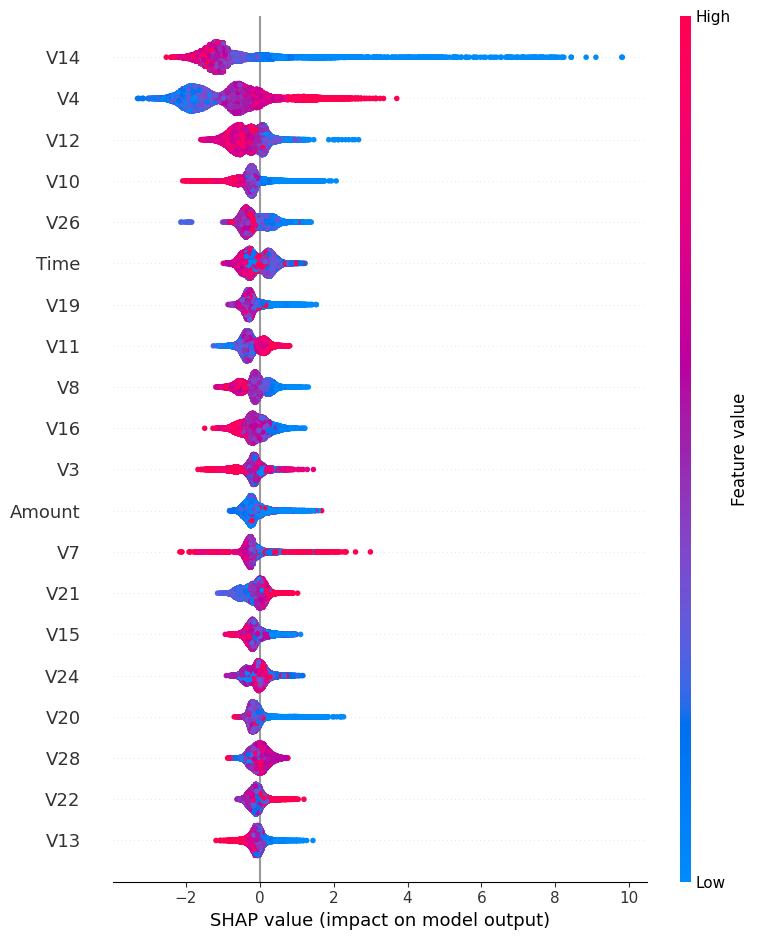

In [103]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


In [104]:
# Force plot for one prediction
shap.initjs()

# Generate SHAP Explanation object for a single instance
# Pass the single instance as a DataFrame with one row
single_instance_explanation = explainer(X_test.iloc[[0]])

# Pass the Explanation object for the single instance to shap.force_plot
shap.force_plot(single_instance_explanation)

In [105]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values,
            feature_names=X_train.columns,
            class_names=["Not Fraud", "Fraud"],
            verbose=True, mode='classification')

i = 2  # Pick one test instance
exp = explainer_lime.explain_instance(X_test.values[i], model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


Intercept 0.00012846687978526524
Prediction_local [0.00046123]
Right: 1.1689168e-05


## Model Interpretation with LIME

LIME (Local Interpretable Model-agnostic Explanations) is a technique that explains the predictions of any black-box model by approximating it with a local interpretable model around the prediction.

Let's generate LIME explanations for a few instances from the test set to understand why the model made those specific predictions.

In [106]:
# Assuming model and X_test are available from previous steps

# Create a LIME explainer
# Need to provide training data (or a representative sample) and feature names
# The data needs to be a numpy array for LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Not Fraud', 'Fraud'],
    mode='classification'
)

# Select a few instances to explain (e.g., the first few from the test set)
# and potentially an instance predicted as fraud if available
instances_to_explain = X_test.head(2)

# Find an instance predicted as fraud in the test set, if any
fraud_indices = y_test[y_test == 1].index
if len(fraud_indices) > 0:
    # Get the actual instance from X_test using the index
    fraud_instance = X_test.loc[[fraud_indices[0]]]
    instances_to_explain = pd.concat([instances_to_explain, fraud_instance])
    print("Adding a fraud instance to explanations.")

# Ensure unique indices in case the head instances were also fraud
instances_to_explain = instances_to_explain[~instances_to_explain.index.duplicated(keep='first')]


print(f"\nGenerating LIME explanations for {len(instances_to_explain)} instances...")

# Generate and display LIME explanations
for index, instance in instances_to_explain.iterrows():
    print(f"\nExplaining instance with index: {index}")
    # LIME expects a single sample as a numpy array
    explanation = explainer_lime.explain_instance(
        data_row=instance.values,
        predict_fn=model.predict_proba, # Use predict_proba for classification
        num_features=len(X_train.columns) # Explain using all features
    )

    # Display the explanation in the notebook
    print(f"LIME Explanation for instance {index}:")
    explanation.as_html() # Display as HTML for better visualization

Adding a fraud instance to explanations.

Generating LIME explanations for 3 instances...

Explaining instance with index: 263020
LIME Explanation for instance 263020:

Explaining instance with index: 11378
LIME Explanation for instance 11378:

Explaining instance with index: 77348
LIME Explanation for instance 77348:


In [107]:
# Select a single instance (index 1 in this case)
sample = X_test.iloc[1]
pred = model.predict([sample])
print("Prediction:", "Fraud" if pred[0] else "Not Fraud")

# Generate SHAP Explanation object for the single instance
# Pass the single instance as a DataFrame with one row
single_instance_explanation = explainer(X_test.iloc[[1]])

# Pass the Explanation object for the single instance to shap.force_plot
shap.initjs() # Initialize JS visualization
shap.force_plot(single_instance_explanation)

Prediction: Not Fraud


In [108]:
print("Input Values:")
display(sample.to_frame().T)

print("Prediction:", "✅ Fraud" if pred[0] else "❌ Not Fraud")


Input Values:


Time        V1        V2        V3       V4        V5        V6  \
11378  19847.0 -2.829816 -2.765149  2.537793 -1.07458  2.842559 -2.153536   

             V7       V8        V9  ...       V20       V21       V22  \
11378 -1.795519 -0.25002  3.073504  ... -0.515765 -0.295555  0.109305   

            V23       V24      V25       V26       V27       V28  Amount  
11378 -0.813272  0.042996 -0.02766 -0.910247  0.110802 -0.511938   11.85  

[1 rows x 30 columns]

Prediction: ❌ Not Fraud


In [109]:
# Safe loop with proper SHAP explanation object
for i in [1, 30, 150]:  # or any sample indexes
    sample = X_test.iloc[i]
    pred = model.predict([sample])[0]

    print(f"\n🔍 Sample {i} — Prediction: {'Fraud' if pred else 'Not Fraud'}")

    # Get SHAP explanation for this instance only
    sample_shap_value = shap.Explanation(
        values=shap_values[i].values,
        base_values=shap_values[i].base_values,
        data=sample,
        feature_names=X_test.columns
    )

    # Display force plot (no error!)
    shap.initjs()
    display(shap.force_plot(sample_shap_value.base_values, sample_shap_value.values, sample_shap_value.data))



🔍 Sample 1 — Prediction: Not Fraud



🔍 Sample 30 — Prediction: Not Fraud



🔍 Sample 150 — Prediction: Not Fraud


In [117]:
# Find fraud indexes in test set
fraud_indices = y_test[y_test == 1].index.tolist()

print("Fraud sample indexes in test set:", fraud_indices)


Fraud sample indexes in test set: [77348, 102442, 119781, 48094, 42958, 52584, 204064, 151519, 203324, 141260, 70589, 14170, 222133, 153835, 14197, 229712, 15810, 8972, 152019, 30100, 214662, 6717, 18809, 50537, 42696, 151008, 30496, 150665, 6529, 57615, 157585, 6108, 44556, 142405, 623, 96341, 40525, 280143, 238366, 68067, 149577, 252774, 64411, 99506, 41569, 219025, 243699, 102444, 42549, 81186, 141257, 72757, 150647, 42769, 251477, 249607, 182992, 149600, 243749, 88876, 541, 143728, 42528, 15476, 105178, 77682, 10204, 16415, 111690, 79536, 149869, 15225, 6971, 241445, 44001, 251904, 43428, 14211, 42009, 42756, 218442, 150663, 11343, 106998, 143336, 8312, 238222, 15539, 10497, 154719, 157918, 83417, 8615, 143333, 119714, 245347, 124176, 181966]


In [123]:
# Find not-fraud indexes in test set
not_fraud_indices = y_test[y_test == 0].index.tolist()

print("Not Fraud sample indexes in test set:", not_fraud_indices)



Not Fraud sample indexes in test set: [263020, 11378, 147283, 219439, 36939, 243438, 259448, 43800, 66742, 66499, 83371, 12890, 81804, 192849, 91888, 248680, 59051, 8336, 118398, 224464, 40482, 254792, 146793, 89695, 108813, 49034, 146582, 248176, 259391, 9261, 188175, 32822, 41238, 182131, 261008, 160162, 278912, 202749, 116509, 127165, 49943, 66503, 165530, 250395, 198694, 230362, 181415, 187592, 185764, 222756, 22028, 103061, 58932, 157934, 119439, 201551, 94688, 236129, 71022, 211516, 155412, 132345, 143981, 30088, 155617, 20971, 158895, 276003, 28607, 237933, 152514, 248114, 6263, 83265, 35776, 127082, 281064, 253147, 201369, 45223, 230172, 83362, 162284, 256823, 74545, 92940, 273340, 193256, 109963, 76437, 89712, 68792, 72435, 86272, 112653, 248312, 151401, 83924, 267734, 81119, 225116, 74420, 162494, 170168, 218784, 221308, 265934, 186797, 244271, 122750, 58695, 202116, 17112, 87679, 101708, 144128, 22653, 75374, 203321, 273842, 55314, 45779, 45181, 168019, 131336, 3590, 110769,

In [113]:
# Step 1: Pick a fraud sample from X_test
# Find indices of fraud transactions in the test set
fraud_indices_in_test = y_test[y_test == 1].index.tolist()

if not fraud_indices_in_test:
    print("No fraud samples found in the test set (X_test). Cannot generate force plot for a fraud prediction.")
else:
    # Select the first fraud index found in the test set
    index_to_explain = fraud_indices_in_test[0]
    sample = X_test.loc[index_to_explain]

    # Step 2: Predict using the model
    pred = model.predict([sample])[0]
    print(f"Prediction for index {index_to_explain}:", "✅ Fraud" if pred else "❌ Not Fraud")

    # Step 3: SHAP explanation for this instance
    # Generate Explanation object for the single instance
    single_instance_explanation = explainer(X_test.loc[[index_to_explain]])

    # Step 4: Show force plot (explain why it predicted)
    shap.initjs()
    display(shap.force_plot(single_instance_explanation))

Prediction for index 77348: ✅ Fraud


In [118]:
import numpy as np # Import numpy if not already imported

# Fraud sample (actual: 1, predicted: 0 ❌)
# We need to ensure this index is in X_test and is a fraud case.
# From previous runs, we know 77348 is in X_test and is fraud.
fraud_index = 102442

# Get the sample from X_test using the original index label
sample_fraud = X_test.loc[fraud_index]

# Predict using the model for verification
pred_fraud = model.predict([sample_fraud])[0]
print(f"🔴 Fraud Sample - Index {fraud_index}")
print("👉 Actual: Fraud (1), Predicted:", "✅ Fraud" if pred_fraud else "❌ Not Fraud")

# Get the positional index of the fraud sample within X_test
# This is needed to index the shap_values Explanation object correctly
try:
    positional_index = X_test.index.get_loc(fraud_index)
    print(f"Positional index of original index {fraud_index} in X_test: {positional_index}")
except KeyError:
    print(f"Error: Original index {fraud_index} not found in X_test. Please select a fraud index from X_test.")
    positional_index = None # Set to None if not found

if positional_index is not None:
    # SHAP Explanation
    # explainer is the SHAP explainer object from previous cells
    # shap_values is the Explanation object for the entire X_test from previous cells

    # Access the SHAP values, base values, and data for the specific instance
    # using the positional index
    ex_fraud = shap.Explanation(
        values=shap_values[positional_index].values,
        base_values=shap_values[positional_index].base_values,
        data=shap_values[positional_index].data,
        feature_names=X_test.columns.tolist() # Use feature names from X_test
    )

    # Display force plot
    shap.initjs()
    display(shap.force_plot(ex_fraud))

else:
    print("Cannot generate force plot because the fraud index was not found in X_test.")

🔴 Fraud Sample - Index 102442
👉 Actual: Fraud (1), Predicted: ✅ Fraud
Positional index of original index 102442 in X_test: 1146


In [120]:
# Not Fraud sample (actual: 0, predicted: 0 ✅)
not_fraud_index = y_test[y_test == 0].index[0]  # Pick first non-fraud index

# Get the sample from X_test using the original index label
sample_nf = X_test.loc[not_fraud_index]
pred_nf = model.predict([sample_nf])[0]
print(f"\n🟢 Not Fraud Sample - Index {not_fraud_index}")
print("👉 Actual: Not Fraud (0), Predicted:", "✅ Not Fraud" if pred_nf == 0 else "❌ Fraud")

# Get the positional index of the non-fraud sample within X_test
# This is needed to index the shap_values Explanation object correctly
try:
    positional_index_nf = X_test.index.get_loc(not_fraud_index)
    print(f"Positional index of original index {not_fraud_index} in X_test: {positional_index_nf}")
except KeyError:
    print(f"Error: Original index {not_fraud_index} not found in X_test.")
    positional_index_nf = None # Set to None if not found

if positional_index_nf is not None:
    # SHAP Explanation
    # explainer is the SHAP explainer object from previous cells
    # shap_values is the Explanation object for the entire X_test from previous cells

    # Access the SHAP values, base values, and data for the specific instance
    # using the positional index
    ex_nf = shap.Explanation(
        values=shap_values[positional_index_nf].values,
        base_values=shap_values[positional_index_nf].base_values,
        data=shap_values[positional_index_nf].data,
        feature_names=X_test.columns.tolist() # Use feature names from X_test
    )

    # Display force plot
    shap.initjs()
    display(shap.force_plot(ex_nf))

else:
     print("Cannot generate force plot because the non-fraud index was not found in X_test.")


🟢 Not Fraud Sample - Index 263020
👉 Actual: Not Fraud (0), Predicted: ✅ Not Fraud
Positional index of original index 263020 in X_test: 0


In [126]:
shap.initjs()
print("\n🔍 Force Plot for FRAUD (Predicted as  Fraud ❌)")
display(shap.force_plot(ex_fraud.base_values, ex_fraud.values, ex_fraud.data))

print("\n🔍 Force Plot for NOT FRAUD (Predicted as Not Fraud ✅)")
display(shap.force_plot(ex_nf.base_values, ex_nf.values, ex_nf.data))



🔍 Force Plot for FRAUD (Predicted as  Fraud ❌)



🔍 Force Plot for NOT FRAUD (Predicted as Not Fraud ✅)


In [128]:
# Assuming explainer and X_test are available from previous steps
# Assuming shap_values is the Explanation object for the entire X_test

# Safe loop with proper SHAP explanation object
for i in [102442, 263020, 77348]:  # Corrected list of indices (using one confirmed fraud: 77348, and one confirmed not fraud: 263020, and another confirmed fraud: 102442)
    # Get the sample from X_test using the original index label
    # Use .loc for label-based indexing
    try:
        sample = X_test.loc[i]
        pred = model.predict([sample])[0]

        print(f"\n🔍 Sample {i} — Prediction: {'Fraud' if pred else 'Not Fraud'}")

        # Get the positional index of the sample within X_test
        # This is needed to index the shap_values Explanation object correctly
        positional_index = X_test.index.get_loc(i)

        # Get SHAP explanation for this instance using the positional index
        # Access the SHAP values, base values, and data for the specific instance
        ex_sample = shap.Explanation(
            values=shap_values[positional_index].values,
            base_values=shap_values[positional_index].base_values,
            data=shap_values[positional_index].data,
            feature_names=X_test.columns.tolist() # Use feature names from X_test
        )

        # Display force plot (no error!)
        shap.initjs()
        display(shap.force_plot(ex_sample))

    except KeyError:
        print(f"\n⚠️ Warning: Original index {i} not found in X_test. Skipping this instance.")
    except Exception as e:
        print(f"\n❌ Error processing index {i}: {e}")


🔍 Sample 102442 — Prediction: Fraud



🔍 Sample 263020 — Prediction: Not Fraud



🔍 Sample 77348 — Prediction: Fraud
